In [179]:
import sys
sys.path.append("/Users/laurenzaisenpreis/Uni/Thesis/tweet-collector")

from fake_collector.utils.TwythonConnector import TwythonConnector
# from fake_collector.modules.user_profile_collector import UserProfileCollector
from fake_collector.utils.TwitterUser import TwitterUser
from fake_collector.configs.directory_config import Directories
from fake_collector.modules.user_profile_collector import UserProfileCollector

In [196]:
import pickle 

directories = Directories()
path = directories.USERS_PATH / "true_users"

# Load the user profiles
filename = "k_2_true_users_recent_tweets.pickle"
with open(path / filename, "rb") as f:
    users_loaded = pickle.load(f)

## Evaluate falsity scores of users

Method of selecting users:

- Select 1 bucket of users as "ground truth" these are the users only posting true news - from this bucket take TOP k according to labeled tweet count
- For the remaining users, select top K users according to their aggregate falsity scores
- Then we are left with {Remaining Users - Top Aggregate Falsity Users}, which we can divide into 4 equal ranges and sample K users from each bucket.

----------------------

Why not normalize by Tweet count? Is the aggregated meaasure not biased towards users who generally Tweet a lot?
- Normalizing by tweet count would push the very inactive Twitter accounts. Instead, we want to account for activity on Twitter

Why not normalize by True tweet count?
- That would suppose, that we could reliably estimate ALL true tweets a user has posted, but our sample just includes very few

Why not normalize by Labeled Tweet count?
- Then we would discard the frequency of tweets and a user who has shared 1000 pants on fire tweets would be equal to a user who shared 1

In [2]:
user_profile_collector = UserProfileCollector()

user_df = user_profile_collector.load_users_profiles_as_df()

In [3]:
user_df.head()

,user_id,user_name,description,followers_count,friends_count,tweet_count,verified,created_at,tweets,retweets,replies,aggregate_falsity_score,average_falsity_score,following_ids,recent_tweets
0,4781209639,Royal Capital Ltd.,We provide #Financial #Economic #Research #Sto...,465,47,537674,False,2016-01-19T03:31:22.000Z,"{'pants-fire': {}, 'false': {}, 'mostly-false'...","{'pants-fire': {}, 'false': {}, 'mostly-false'...","{'pants-fire': {}, 'false': {}, 'mostly-false'...",0.0,0.000000,[],[]
1,288837868,America 1st Patriots for President Donald J Trump,#TrumpTrain #Trump2020,4997,888,68763,False,2011-04-27T15:07:56.000Z,"{'pants-fire': {}, 'false': {'terrorism': ['87...","{'pants-fire': {}, 'false': {}, 'mostly-false'...","{'pants-fire': {}, 'false': {}, 'mostly-false'...",2.4,0.400000,[],[]
2,289019185,Elizabeth Hawkes,Keep looking up,1445,1813,66140,False,2011-04-27T21:39:20.000Z,"{'pants-fire': {}, 'false': {'health-care': ['...","{'pants-fire': {}, 'false': {'elections': ['10...","{'pants-fire': {}, 'false': {}, 'mostly-false'...",7.6,0.584615,[],[]
3,1644617977,13 News Network,"News from around the web, packaged up and spoo...",1753,22,4222,False,2013-08-04T07:05:57.000Z,{'pants-fire': {'terrorism': ['743377551532253...,"{'pants-fire': {}, 'false': {}, 'mostly-false'...","{'pants-fire': {}, 'false': {}, 'mostly-false'...",63.0,0.692308,[],[]
4,75291620,Samuel I Olekanma,Herb Consultant | Ask me how I help sick and d...,1416,1042,16097,False,2009-09-18T14:21:51.000Z,{'pants-fire': {'terrorism': ['743466935321432...,"{'pants-fire': {}, 'false': {}, 'mostly-false'...","{'pants-fire': {}, 'false': {}, 'mostly-false'...",205.0,0.690236,[],[]


In [4]:
# Lowercase description text
user_df['description'] = user_df['description'].map(str.lower)

In [5]:
print('Users with politifact in their description: ', len(user_df[user_df['description'].str.contains('politifact')]))

Users with politifact in their description:  44


In [6]:
# Load users as objects
users_object = user_profile_collector.load_users_profiles_as_dict()

In [7]:
# Add the labeled tweet count to the user df
user_df['labeled_tweet_count'] = user_df.apply(lambda x: len(users_object.get(x['user_id']).get_all_true_tweets_retweets()) + len(users_object.get(x['user_id']).get_all_false_tweets_retweets()), axis=1)

In [8]:
# Calculate aggregate falsity score divided by general tweet count
user_df['avg_falsity_tweetcount'] = user_df['aggregate_falsity_score'] / user_df['tweet_count']

In [127]:
"""
TEST:
remove all the outliers with too many tweets per day from dataset
"""
from datetime import datetime
from datetime import date
import pandas as pd

# Get days since creation
today = date.today()

# Do it for initial DS as well
user_df['days_since_created'] = user_df['created_at'].apply(lambda x: (today - pd.to_datetime(x, format='%Y-%m-%d').date()).days)

In [128]:
# Calc tweet activity
user_df['tweet_activity'] = user_df['tweet_count'] / user_df['days_since_created']

In [148]:
# Get quartiles
quartiles = user_df['tweet_activity'].quantile(q=[0.25,0.75])

q1 = quartiles[0.25]
q3 = quartiles[0.75]

IQR = q3 - q1

upper_fence_activity = q3 + (IQR * 1.5)

print(upper_fence_activity)

25.116824870427408


In [147]:
# Get quartiles for follower count
quartiles = user_df['followers_count'].quantile(q=[0.25,0.75])

q1 = quartiles[0.25]
q3 = quartiles[0.75]

IQR = q3 - q1

upper_fence_followers = q3 + (IQR * 1.5)

print(upper_fence_followers)

2063.0


In [175]:
# Remove outliers based on tweeting activity
outlier_removal = user_df[user_df['tweet_activity'] <= upper_fence_activity]

In [9]:
# Filter out users that only have replies (those ones have agg falsity score -1)
user_df = user_df[user_df['aggregate_falsity_score'] >= 0]

# Users with at least one tweet
user_df = user_df[user_df['tweet_count'] > 0]

# Split into true users and fake users
true_users = user_df[user_df['aggregate_falsity_score'] == 0]
fake_users = user_df[user_df['aggregate_falsity_score'] > 0]

In [10]:
print("Amount of true users", len(true_users))
print("Amount of fake users", len(fake_users))

Amount of true users 56841
Amount of fake users 1437937


In [176]:
outlier_removal_fake = outlier_removal[outlier_removal['aggregate_falsity_score'] > 0]
outlier_removal_true = outlier_removal[outlier_removal['aggregate_falsity_score'] == 0]

In [222]:
# Filter out politifact accounts
outlier_removal_fake = outlier_removal_fake[~outlier_removal_fake['user_name'].str.contains('PolitiFact')]

In [224]:
print("Amount of true users wo outliers", len(outlier_removal_true))
print("Amount of fake users wo outliers", len(outlier_removal_fake))

Amount of true users wo outliers 54013
Amount of fake users wo outliers 1283633


In [ ]:
# Saved the true users with outlier removal

### Explore falsity score distribution

Mean labeled tweet count 1.8708119844223388
Median labeled tweet count 1.0


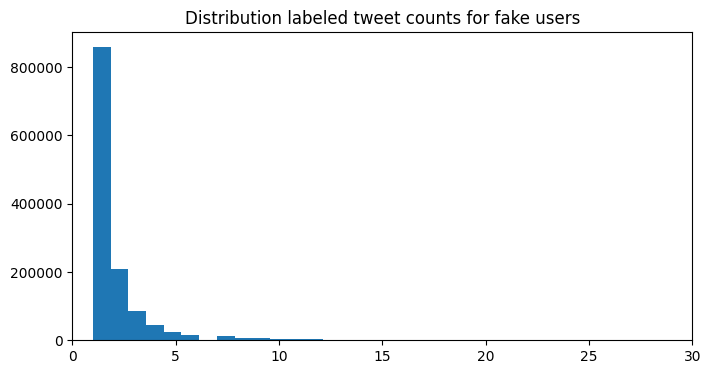

In [225]:
# Distribution of labeled tweet counts for fake users

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,4))

ax.hist(outlier_removal_fake['labeled_tweet_count'], bins=1000)
ax.set_xlim(0,30)

ax.title.set_text("Distribution labeled tweet counts for fake users")
print("Mean labeled tweet count", outlier_removal_fake['labeled_tweet_count'].mean())
print("Median labeled tweet count", outlier_removal_fake['labeled_tweet_count'].median())

In [228]:
outlier_removal_fake_min_tweet = outlier_removal_fake[outlier_removal_fake['labeled_tweet_count'] >= 10]
len(outlier_removal_fake_min_tweet)

19463

In [229]:
outlier_removal_fake_min_tweet['aggregate_falsity_score'].corr(outlier_removal_fake_min_tweet['tweet_count'])

0.056178853529392926

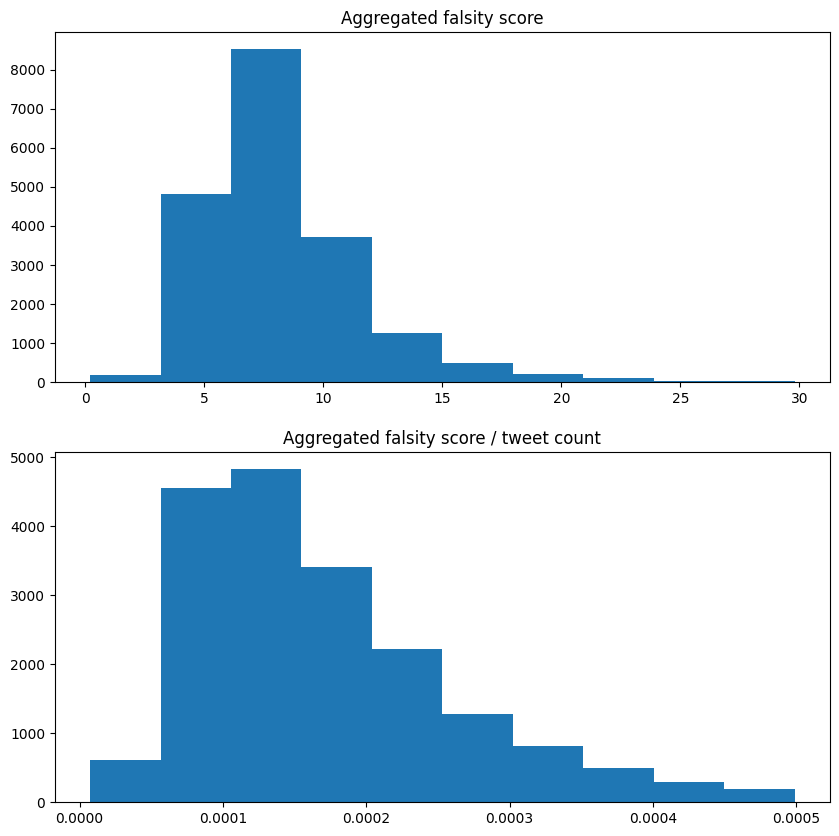

In [237]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10,10))

ax1.hist(outlier_removal_fake_min_tweet[outlier_removal_fake_min_tweet['aggregate_falsity_score'] < 30]['aggregate_falsity_score'])
ax2.hist(outlier_removal_fake_min_tweet[outlier_removal_fake_min_tweet['avg_falsity_tweetcount'] < 0.0005]['avg_falsity_tweetcount'])

ax1.title.set_text("Aggregated falsity score")
ax2.title.set_text("Aggregated falsity score / tweet count")


### Split into equally sized chunks

In [240]:
import pandas as pd

# Function that splits dataframe in 5 equal chunks (quintiles) based on column

def split_in_chunks(df: pd.DataFrame, column: str):

    df = df.copy()

    labels = ["very_low", "low", 'medium', "high", 'very_high']

    df["group_"+column] = pd.qcut(df[column], q=5, labels=labels)
    
    return df

In [242]:
final_df = split_in_chunks(outlier_removal_fake_min_tweet, 'aggregate_falsity_score')

In [255]:
users_object.get('4781209639').get_all_true_tweets_retweets()

['755743427896156160']

In [268]:
final_df.loc[final_df['user_id'] == '289019185', 'group_aggregate_falsity_score'].values[0]

'medium'

In [271]:
fake_users_ids = set(final_df['user_id'])

save_users = {"very_low" : {},
"low" : {},
"medium" : {},
"high": {},
"very_high" : {}
}

for user_id in fake_users_ids:
    group = final_df.loc[final_df['user_id'] == user_id, 'group_aggregate_falsity_score'].values[0]
    save_users.get(group)[user_id] = users_object.get(user_id) 

In [276]:
with open('../../data/users/fake_users/fake_users.pickle', "wb") as f:
    pickle.dump(save_users, f)

In [278]:
with open('../../data/users/fake_users/fake_users.pickle', "rb") as f:
    loaded = pickle.load(f)

In [284]:
# Put fake users into df
users_dict = {}

for fake_group in loaded.keys():
    user_ids = loaded.get(fake_group).keys()
    # Loop through those fake users
    for user_id in loaded.get(fake_group).keys():
        # Add them to dict
        users_dict[user_id] = loaded.get(fake_group).get(user_id).get_user_as_dict()
        users_dict.get(user_id)['fake_group'] = fake_group

In [292]:
# Load as df
users_dict_df = pd.DataFrame.from_dict(users_dict.values())

# Sort values by aggregate falsity score
users_dict_df.sort_values(by='aggregate_falsity_score', ascending=False, inplace=True)

In [305]:
users_dict_df[users_dict_df['fake_group'] == 'very_low']

,user_id,user_name,description,followers_count,friends_count,tweet_count,verified,created_at,tweets,retweets,replies,aggregate_falsity_score,average_falsity_score,following_ids,recent_tweets,fake_group
475,39682563,Evelyn Turner🇺🇸🌊☮,Proud liberal. Photographer.\nHi-tech career w...,1310,2285,26343,False,2009-05-13T03:57:51.000Z,"{'pants-fire': {}, 'false': {}, 'mostly-false'...",{'pants-fire': {'elections': ['139364447174141...,"{'pants-fire': {}, 'false': {}, 'mostly-false'...",5.8,0.580000,[],[],very_low
453,18601783,REIDHANSON,"physical therapist, fingerstyle guitar player ...",252,1252,66973,False,2009-01-04T13:29:19.000Z,"{'pants-fire': {}, 'false': {}, 'mostly-false'...",{'pants-fire': {'ethics': ['132665719551833293...,"{'pants-fire': {}, 'false': {}, 'mostly-false'...",5.8,0.527273,[],[],very_low
456,56489083,Andi Smith,"Just a reminder, at the end of Chicken Little ...",1333,930,33333,False,2009-07-13T20:52:07.000Z,"{'pants-fire': {}, 'false': {}, 'mostly-false'...",{'pants-fire': {'candidates-biography': ['1199...,"{'pants-fire': {}, 'false': {}, 'mostly-false'...",5.8,0.580000,[],[],very_low
69,606850755,Dee D.,"Teams: RBNY, USMNT, Azzurri, AS Roma. Loves Ha...",471,758,59011,False,2012-06-13T00:46:38.000Z,"{'pants-fire': {}, 'false': {}, 'mostly-false'...",{'pants-fire': {'elections': ['132407532865503...,"{'pants-fire': {}, 'false': {}, 'mostly-false'...",5.8,0.527273,[],[],very_low
3071,45239771,Joe Anderson,YOLO. Grateful Dead kid from California. #Unit...,1875,4953,104516,False,2009-06-06T23:35:30.000Z,"{'pants-fire': {}, 'false': {}, 'mostly-false'...",{'pants-fire': {'candidates-biography': ['1433...,"{'pants-fire': {}, 'false': {}, 'mostly-false'...",5.8,0.580000,[],[],very_low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3906,303184200,Alice Riehl☮️,"Writer, retired newspaper owner Proud #Resiste...",3033,4965,50997,False,2011-05-22T12:51:32.000Z,"{'pants-fire': {}, 'false': {}, 'mostly-false'...","{'pants-fire': {}, 'false': {}, 'mostly-false'...","{'pants-fire': {}, 'false': {}, 'mostly-false'...",1.6,0.160000,[],[],very_low
3610,831914940025888768,A groundhogs day of FuccShii,Politicking & Rachetness.\n$DRhod87,563,952,48035,False,2017-02-15T17:15:52.000Z,"{'pants-fire': {}, 'false': {}, 'mostly-false'...","{'pants-fire': {}, 'false': {'legal-issues': [...","{'pants-fire': {}, 'false': {}, 'mostly-false'...",1.4,0.140000,[],[],very_low
2308,14335586,Public Citizen,Public Citizen has been standing up to corpora...,537649,7556,40159,True,2008-04-08T20:07:57.000Z,"{'pants-fire': {}, 'false': {}, 'mostly-false'...","{'pants-fire': {}, 'false': {}, 'mostly-false'...","{'pants-fire': {}, 'false': {}, 'mostly-false'...",0.8,0.080000,[],[],very_low
2589,18001922,Live Action,A global human rights movement dedicated to en...,159231,2682,55031,True,2008-12-09T20:48:11.000Z,"{'pants-fire': {}, 'false': {}, 'mostly-false'...","{'pants-fire': {}, 'false': {}, 'mostly-false'...","{'pants-fire': {}, 'false': {}, 'mostly-false'...",0.4,0.020000,[],[],very_low


In [297]:
# Load specific fake group as df
key = "medium"

users = loaded.get(key)

users_med_dict = {user_id : users.get(user_id).get_user_as_dict() for user_id in users.keys()}

users_df_med = pd.DataFrame.from_dict(users_med_dict.values())

users_df_med['fake_group'] = key

users_df_med

,user_id,user_name,description,followers_count,friends_count,tweet_count,verified,created_at,tweets,retweets,replies,aggregate_falsity_score,average_falsity_score,following_ids,recent_tweets,fake_group
0,448415833,Joe Grizzly,,221,1402,60903,False,2011-12-28T00:08:50.000Z,"{'pants-fire': {}, 'false': {}, 'mostly-false'...",{'pants-fire': {'trade': ['1524160747969949696...,"{'pants-fire': {}, 'false': {}, 'mostly-false'...",7.8,0.709091,[],[],medium
1,2747035544,Liberal To The Core🇺🇸🌊,Profile name says it all MOST important VOTE o...,4432,4947,52176,False,2014-08-19T22:41:20.000Z,"{'pants-fire': {}, 'false': {}, 'mostly-false'...",{'pants-fire': {'candidates-biography': ['1199...,"{'pants-fire': {}, 'false': {}, 'mostly-false'...",7.6,0.584615,[],[],medium
2,194221611,Greg Olsen,Ex-Military Ex Computer Helpdesk Working at Re...,349,600,51288,False,2010-09-23T18:36:11.000Z,{'pants-fire': {'fake-news': ['102648083734742...,"{'pants-fire': {}, 'false': {'fires': ['130398...",{'pants-fire': {'fake-news': ['980045308506918...,7.8,0.780000,[],[],medium
3,569578376,🇭🇲🇬🇧UNFILTERED🇺🇸🇳🇿,NOT AN EXPERT. I don't get paid for my opinion...,1378,1441,59017,False,2012-05-03T01:25:50.000Z,"{'pants-fire': {}, 'false': {'facebook-fact-ch...",{'pants-fire': {'elections': ['132694790748480...,{'pants-fire': {'elections': ['133298613615155...,7.4,0.740000,[],[],medium
4,169364304,Joshua Reed,,786,4874,33210,False,2010-07-22T04:35:56.000Z,"{'pants-fire': {}, 'false': {}, 'mostly-false'...",{'pants-fire': {'states': ['134664825912578048...,"{'pants-fire': {}, 'false': {}, 'mostly-false'...",7.4,0.616667,[],[],medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3888,522594399,🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸 Paula,49er Fan since 1970's even before the years of...,636,1204,55162,False,2012-03-12T21:22:54.000Z,{'pants-fire': {'islam': ['383681850150891520'...,{'pants-fire': {'jan-6': ['1394412768967761922...,"{'pants-fire': {}, 'false': {}, 'mostly-false'...",7.6,0.584615,[],[],medium
3889,336293084,Charlie J. Garrett,,592,1245,38054,False,2011-07-16T01:56:38.000Z,"{'pants-fire': {}, 'false': {}, 'mostly-false'...",{'pants-fire': {'immigration': ['1483167871492...,"{'pants-fire': {}, 'false': {}, 'mostly-false'...",7.8,0.709091,[],[],medium
3890,256804632,Anonymous Free Speech,American Homosapien exercising God's will by s...,195,806,53226,False,2011-02-24T03:18:09.000Z,"{'pants-fire': {}, 'false': {}, 'mostly-false'...",{'pants-fire': {'jan-6': ['1394133361862578185...,"{'pants-fire': {}, 'false': {}, 'mostly-false'...",7.6,0.633333,[],[],medium
3891,1941083934,Dave Hervey,,215,427,32555,False,2013-10-06T14:25:24.000Z,"{'pants-fire': {}, 'false': {}, 'mostly-false'...","{'pants-fire': {}, 'false': {'facebook-fact-ch...","{'pants-fire': {}, 'false': {}, 'mostly-false'...",7.2,0.654545,[],[],medium


### Calculate overlapping users depending on which column to split among

In [22]:
# Calculate overlap of users for each group

def overlapping_users_chunks(df: pd.DataFrame, column1: str, column2: str):

    df = df.copy()

    # Get labels
    labels = ["very_low", "low", 'medium', "high", 'very_high']

    # Generate splits
    for column in [column1, column2]:
        df = split_in_chunks(df, column=column)
    
    chunk_1 = "chunk_" + column1
    chunk_2 = "chunk_" + column2

    # Calculate overlap
    for label in labels:

        users1 = set(df.loc[df[chunk_1] == label, 'user_id'])
        users2 = set(df.loc[df[chunk_2] == label, 'user_id'])
        
        intersection = users1.intersection(users2)
        union = users1.union(users2)

        overlap = (len(intersection) / len(union)) * 100

        print(f'Overlap for {label}: {overlap} %')


In [77]:
overlapping_users_chunks(fake_users_min_tweet, column1='aggregate_falsity_score', column2='average_falsity_score')

Overlap for very_low: 44.38758103036506 %
Overlap for low: 12.184520471116096 %
Overlap for medium: 11.110357457776573 %
Overlap for high: 13.25144111995608 %
Overlap for very_high: 15.18109790605546 %


In [27]:
overlapping_users_chunks(fake_users_min_tweet, column1='aggregate_falsity_score', column2='aggregated_falsity_normalized_true')

Overlap for very_low: 46.29581037348028 %
Overlap for low: 12.790212706798275 %
Overlap for medium: 11.644444444444444 %
Overlap for high: 14.579581659509627 %
Overlap for very_high: 18.850423605024833 %


In [28]:
overlapping_users_chunks(fake_users_min_tweet, column1='average_falsity_score', column2='aggregated_falsity_normalized_true')

Overlap for very_low: 81.01458741563249 %
Overlap for low: 59.43451796583547 %
Overlap for medium: 51.33069343401786 %
Overlap for high: 47.33345304363441 %
Overlap for very_high: 68.44864809293718 %


In [29]:
# Correlation between agg falsity score and tweet count
fake_users_min_tweet['aggregate_falsity_score'].corr(fake_users_min_tweet['tweet_count'], method='pearson')

0.42020557283833787

In [30]:
# Correlation between avg falsity score and tweet count
fake_users_min_tweet['average_falsity_score'].corr(fake_users_min_tweet['tweet_count'], method='pearson')

-0.04811455021367796

In [31]:
# Correlation between normalized falsity score and tweet count
fake_users_min_tweet['aggregated_falsity_normalized_true'].corr(fake_users_min_tweet['tweet_count'], method='pearson')

-0.06044432954717672

### Filter bots & institutions

In [119]:
from datetime import datetime
from datetime import date

# Get days since creation
today = date.today()

fake_users_min_tweet['days_since_created'] = fake_users_min_tweet['created_at'].apply(lambda x: (today - pd.to_datetime(x, format='%Y-%m-%d').date()).days)

# Do it for initial DS as well
fake_users['days_since_created'] = fake_users['created_at'].apply(lambda x: (today - pd.to_datetime(x, format='%Y-%m-%d').date()).days)

/var/folders/0v/j9gmpz5x1zj_yj09shj112wc0000gn/T/ipykernel_2297/471067870.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fake_users['days_since_created'] = fake_users['created_at'].apply(lambda x: (today - pd.to_datetime(x, format='%Y-%m-%d').date()).days)


In [120]:
# Calc tweet activity
fake_users_min_tweet['tweet_activity'] = fake_users_min_tweet['tweet_count'] / fake_users_min_tweet['days_since_created']

fake_users['tweet_activity'] = fake_users['tweet_count'] / fake_users['days_since_created']

/var/folders/0v/j9gmpz5x1zj_yj09shj112wc0000gn/T/ipykernel_2297/3889583600.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fake_users['tweet_activity'] = fake_users['tweet_count'] / fake_users['days_since_created']


#### Setting a threshold for tweet activity cutoff

In [169]:
# Get quartiles
quartiles = fake_users_min_tweet['tweet_activity'].quantile(q=[0.25,0.75])

q1 = quartiles[0.25]
q3 = quartiles[0.75]

IQR = q3 - q1

upper_fence = q3 + (IQR * 1.5)

print(upper_fence)

121.11462908182679


In [107]:
fake_users_outlier_removed = fake_users_min_tweet[fake_users_min_tweet['tweet_activity'] <= upper_fence]

In [167]:
overlapping_users_chunks(fake_users_outlier_removed, column1='aggregate_falsity_score', column2='average_falsity_score')

Overlap for very_low: 45.25886064204862 %
Overlap for low: 12.618994908124861 %
Overlap for medium: 10.926908340701443 %
Overlap for high: 12.88618184486681 %
Overlap for very_high: 16.71394617802653 %


In [168]:
# Correlation between agg falsity score and tweet count
fake_users_outlier_removed['aggregate_falsity_score'].corr(fake_users_outlier_removed['tweet_count'], method='pearson')

0.34934395017245207

In [110]:
# Remove outliers
fake_users_outlier_removed.sort_values(by='aggregate_falsity_score', ascending=False).head(30)

,user_id,user_name,description,followers_count,friends_count,tweet_count,verified,created_at,tweets,retweets,...,aggregate_falsity_score,average_falsity_score,following_ids,recent_tweets,labeled_tweet_count,avg_falsity_tweetcount,aggregated_falsity_normalized_true,days_since_created,tweet_activity,tweet_activity_qt
5,175472734,Samuel Olekanma,i prophet samuel olekanma a born servant of je...,1557,1226,42630,False,2010-08-06T18:12:45.000Z,{'pants-fire': {'terrorism': ['743466926949556...,"{'pants-fire': {}, 'false': {}, 'mostly-false'...",...,581.8,0.678880,[],[],857,0.013648,3.144865,4458,9.562584,33.432314
348,234922535,Bill Badey,"🇺🇸 retired dod/da. 23d infantry division, viet...",3265,3626,392921,False,2011-01-06T22:29:54.000Z,{'pants-fire': {'legal-issues': ['674936914806...,"{'pants-fire': {}, 'false': {'immigration': ['...",...,541.2,0.562578,[],[],962,0.001377,2.130709,4305,91.270848,33.432314
4,75291620,Samuel I Olekanma,herb consultant | ask me how i help sick and d...,1416,1042,16097,False,2009-09-18T14:21:51.000Z,{'pants-fire': {'terrorism': ['743466935321432...,"{'pants-fire': {}, 'false': {}, 'mostly-false'...",...,205.0,0.690236,[],[],297,0.012735,3.360656,4780,3.367573,33.432314
1323673,855661340458921984,Cheap Smoke!,stay tuned! we are building a website just for...,804,2407,37783,False,2017-04-22T05:55:35.000Z,"{'pants-fire': {}, 'false': {'drugs': ['158112...","{'pants-fire': {}, 'false': {}, 'mostly-false'...",...,176.8,0.800000,[],[],221,0.004679,176.800000,2007,18.825610,33.432314
39,8953122,PolitiFact,home of the truth-o-meter and independent fact...,687205,7894,62429,True,2007-09-18T15:08:32.000Z,{'pants-fire': {'candidates-biography': ['8937...,{'pants-fire': {'recreation': ['10044908331969...,...,175.8,0.520118,[],[],338,0.002816,1.078528,5511,11.328071,33.432314
351,91853518,NECC,"inside the pale of anchorage, alaska's largest...",218,120,56265,False,2009-11-22T19:40:56.000Z,{'pants-fire': {'history': ['55649846106931200...,"{'pants-fire': {}, 'false': {}, 'mostly-false'...",...,136.8,0.456000,[],[],300,0.002431,0.786207,4715,11.933192,33.432314
147798,1213709566426284032,Omar Mohammad,content analyst,3,1,1013,False,2020-01-05T06:31:52.000Z,"{'pants-fire': {}, 'false': {}, 'mostly-false'...","{'pants-fire': {}, 'false': {'coronavirus': ['...",...,125.6,0.800000,[],[],157,0.123988,125.600000,1019,0.994112,33.432314
140215,1911303422,The Daily Fetched,fetching your news,38638,33486,171029,False,2013-09-27T14:28:19.000Z,{'pants-fire': {'fake-news': ['903720671032823...,{'pants-fire': {'health-care': ['1056489552121...,...,112.2,0.825000,[],[],136,0.000656,28.050000,3310,51.670393,33.432314
267,915201700671184896,amjad mohammad,🐸,12,13,3154,False,2017-10-03T13:07:43.000Z,"{'pants-fire': {}, 'false': {}, 'mostly-false'...",{'pants-fire': {'facebook-fact-checks': ['1232...,...,110.4,0.830075,[],[],133,0.035003,110.400000,1843,1.711340,33.432314
234161,60329634,George Jarkesy. Jr,"entrepreneur, fund manager, chairman of nation...",16998,15606,136399,False,2009-07-26T15:45:24.000Z,"{'pants-fire': {}, 'false': {}, 'mostly-false'...","{'pants-fire': {}, 'false': {'immigration': ['...",...,97.0,0.598765,[],[],162,0.000711,32.333333,4834,28.216591,33.432314


In [118]:
fake_users_outlier_removed[fake_users_outlier_removed['user_name'].str.contains('News')].head(30)

,user_id,user_name,description,followers_count,friends_count,tweet_count,verified,created_at,tweets,retweets,...,aggregate_falsity_score,average_falsity_score,following_ids,recent_tweets,labeled_tweet_count,avg_falsity_tweetcount,aggregated_falsity_normalized_true,days_since_created,tweet_activity,tweet_activity_qt
3,1644617977,13 News Network,"news from around the web, packaged up and spoo...",1753,22,4222,False,2013-08-04T07:05:57.000Z,{'pants-fire': {'terrorism': ['743377551532253...,"{'pants-fire': {}, 'false': {}, 'mostly-false'...",...,63.0,0.692308,[],[],91,0.014922,3.000000,3364,1.255054,33.432314
4230,976670026911580160,News Hound,,199,964,63663,False,2018-03-22T04:00:54.000Z,"{'pants-fire': {}, 'false': {}, 'mostly-false'...",{'pants-fire': {'climate-change': ['1166209368...,...,7.8,0.600000,[],[],13,0.000123,1.950000,1673,38.053198,33.432314
6306,1367531,Fox News,"follow america's #1 cable news network, delive...",22460698,261,500587,True,2007-03-17T19:01:26.000Z,{'pants-fire': {'guns': ['927883743242489857']...,"{'pants-fire': {}, 'false': {'economy': ['6642...",...,18.6,0.502703,[],[],37,0.000037,0.930000,5696,87.883954,33.432314
6549,483429828,US & World News,#uspoliticalworldnewsviews progressive populis...,5291,5532,472046,False,2012-02-05T00:53:19.000Z,{'pants-fire': {'health-care': ['8609123092496...,{'pants-fire': {'welfare': ['54324204215586406...,...,11.0,0.523810,[],[],21,0.000023,1.100000,3910,120.727877,33.432314
7706,457984599,Breitbart News,"news, commentary, and destruction of the polit...",1652897,110,165638,True,2012-01-08T01:50:52.000Z,{'pants-fire': {'education': ['247323146502414...,"{'pants-fire': {}, 'false': {'criminal-justice...",...,6.8,0.618182,[],[],11,0.000041,1.700000,3938,42.061453,33.432314
8396,7587032,Sky News,for breaking news @skynewsbreak. watch live on...,8112484,23,549157,True,2007-07-19T14:42:53.000Z,"{'pants-fire': {}, 'false': {'congress': ['126...","{'pants-fire': {}, 'false': {}, 'mostly-false'...",...,9.8,0.753846,[],[],13,0.000018,9.800000,5572,98.556533,33.432314
9648,281719971,@M633News 🇵🇦 Tomas Portillo,m633 es un blog para latinoamericano cristiano...,792,459,94099,False,2011-04-13T20:53:12.000Z,{'pants-fire': {'guns': ['927886216594378753']...,{'pants-fire': {'legal-issues': ['122503431631...,...,9.6,0.685714,[],[],14,0.000102,2.400000,4208,22.361930,33.432314
10277,15012486,CBS News,your source for original reporting and trusted...,8808116,597,351959,True,2008-06-05T00:54:31.000Z,{'pants-fire': {'elections': ['153721447311036...,"{'pants-fire': {}, 'false': {'taxes': ['958526...",...,13.4,0.744444,[],[],18,0.000038,2.680000,5250,67.039810,33.432314
10456,14173315,NBC News,"news updates from around the 🌎, all day, every...",9304647,1862,351498,True,2008-03-18T23:19:17.000Z,{'pants-fire': {'elections': ['139256979674784...,{'pants-fire': {'fake-news': ['106902995760156...,...,12.2,0.677778,[],[],18,0.000035,2.440000,5329,65.959467,33.432314
10575,1650858084,The Good News Goddess,truth is light but the light can sometimes bur...,996,3854,259315,False,2013-08-06T18:06:24.000Z,"{'pants-fire': {}, 'false': {}, 'mostly-false'...",{'pants-fire': {'candidates-biography': ['9353...,...,13.6,0.544000,[],[],25,0.000052,1.236364,3362,77.131172,33.432314


In [90]:
import botometer

rapidapi_key = "a0e194e750mshf3c6bed3a1ae024p1d3384jsn2be3926c4d4f"
twitter_app_auth = {
    'consumer_key': 'aXEijjlLq74puA8mEnnpJvbEk',
    'consumer_secret': 'KptmXnylEe2sYUHAappz3o7BLIPKOJjpabFmBiTGDijvpBhcJ2',
    'access_token': '1513121638333751297-528UgzWJRV4si1dWG9mConxMYKJzlT',
    'access_token_secret': 'YKZ0dro79byeFpuTbdSVh23mtXWKuG328stXFR3xsmp3f',
  }
bom = botometer.Botometer(wait_on_ratelimit=True,
                          rapidapi_key=rapidapi_key,
                          **twitter_app_auth)

# Check a single account by screen name
result = bom.check_account('@clayadavis')

# Check a single account by id
result = bom.check_account(1548959833)

# Check a sequence of accounts
accounts = ['@clayadavis', '@onurvarol', '@jabawack']
for screen_name, result in bom.check_accounts_in(accounts):
    # Do stuff with screen_name and result
    print(result)


{'cap': {'english': 0.4197222421546159, 'universal': 0.5222398722127631}, 'display_scores': {'english': {'astroturf': 0.0, 'fake_follower': 1.0, 'financial': 0.0, 'other': 0.4, 'overall': 0.4, 'self_declared': 0.2, 'spammer': 0.0}, 'universal': {'astroturf': 0.1, 'fake_follower': 1.0, 'financial': 0.0, 'other': 0.3, 'overall': 0.6, 'self_declared': 0.0, 'spammer': 0.0}}, 'raw_scores': {'english': {'astroturf': 0.01, 'fake_follower': 0.19, 'financial': 0.0, 'other': 0.07, 'overall': 0.08, 'self_declared': 0.04, 'spammer': 0.01}, 'universal': {'astroturf': 0.02, 'fake_follower': 0.19, 'financial': 0.0, 'other': 0.06, 'overall': 0.11, 'self_declared': 0.0, 'spammer': 0.01}}, 'user': {'majority_lang': 'en', 'user_data': {'id_str': '1548959833', 'screen_name': 'clayadavis'}}}
{'cap': {'english': 0.4756769663222349, 'universal': 0.43650814830094437}, 'display_scores': {'english': {'astroturf': 0.8, 'fake_follower': 0.4, 'financial': 0.0, 'other': 1.1, 'overall': 0.5, 'self_declared': 0.0, 's

### User buckets

In [ ]:
# Filter out users that only have replies (those ones have agg falsity score -1)
print("Users prior ", len(user_df))
user_df = user_df[user_df['aggregate_falsity_score'] >= 0]
print("Users after ", len(user_df))

In [ ]:
# Check which users have posts ONLY true tweets or retweets
user_df['only_true'] = user_df.apply(lambda x: 1 if 
                        (len(users_object.get(x['user_id']).get_all_false_tweets_retweets()) == 0) 
                        & (len(users_object.get(x['user_id']).get_half_true_tweets()) == 0) 
                        & (len(users_object.get(x['user_id']).get_half_true_retweets()) == 0) 
                        & (len(users_object.get(x['user_id']).get_mostly_true_tweets()) == 0) 
                        & (len(users_object.get(x['user_id']).get_mostly_true_retweets()) == 0) 
                        else 0, axis=1)

In [ ]:
print("Users with only TRUE news ", len(user_df[user_df['only_true'] == 1]))
only_true = user_df[user_df['only_true'] == 1].copy()

In [ ]:
# Get the true tweet count
only_true['true_tweet_count'] = only_true.apply(lambda x: (len(users_object.get(x['user_id']).get_true_tweets())) + len(users_object.get(x['user_id']).get_true_retweets()), axis=1)

In [ ]:
only_true[only_true['true_tweet_count'] > 1]

In [ ]:
# Users that have mostly fake news (everything except TRUE news)
mostly_fake = user_df[~user_df['user_id'].isin(only_true['user_id'])]

In [ ]:
# Users that only post fake news (PANTS, FAKE, MOSTLY FAKE) and only post true news (HALF, MOSTLY, TRUE)
user_df['only_fake'] = user_df.apply(lambda x: 1 if (len(users_object.get(x['user_id']).get_all_true_tweets_retweets())) == 0 else 0, axis=1)

In [ ]:
all_fake_labels_only = user_df[user_df['only_fake'] == 1]

In [ ]:
all_true_labels_only = user_df[~user_df['user_id'].isin(all_fake_labels_only['user_id'])]

In [ ]:
print("Only fake news users ", len(user_df[user_df['only_fake'] == 1]))
user_df[user_df['only_fake'] == 1].head(2)

In [ ]:
print("Users that have both true and fake news", len(user_df[(user_df['only_fake'] == 0) & (user_df['only_true'] == 0)]))

In [ ]:
len(user_df[user_df['only_true'] == 1]) # 101895 Only true
len(user_df[user_df['only_fake'] == 1]) # 350860 Only fake
len(user_df[(user_df['only_fake'] == 0) & (user_df['only_true'] == 0)]) # 37850 both

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()

labels = ["Only true", "Only fake", "Both"]

ax.bar(1, len(user_df), label="All users")
ax.bar(2, len(mostly_fake), label="All fake + mostly/half true") # All the fake labels plus half, mostly true
ax.bar(3, len(only_true), label="Only true label")
ax.bar(4, len(all_fake_labels_only), label="All fake labels only") # All the fake labels NOT any true
ax.bar(5, len(all_true_labels_only), label="All true labels only") # All the fake labels NOT any true


ax.set_ylabel("Number of users")
fig.legend()
ax.axes.get_xaxis().set_visible(False)

In [ ]:
# only_fake['normalized_falsity_score'] = only_fake.apply(lambda x: x['aggregate_falsity_score']/(1+users_obj.get(x['user_id']).tweet_count), axis=1)

In [ ]:
# only_fake[only_fake['normalized_falsity_score'] > 0.009]['tweet_count'].mean()

In [ ]:
import seaborn as sns

sns.kdeplot(mostly_fake['aggregate_falsity_score']) 

In [ ]:
sns.kdeplot(mostly_fake[mostly_fake['aggregate_falsity_score'] < 10]['aggregate_falsity_score'])

In [ ]:
sns.kdeplot(all_fake_labels_only['aggregate_falsity_score']) 

In [ ]:
# Only true according to tweet count
sns.kdeplot(only_true['true_tweet_count'])

In [ ]:
sns.kdeplot(both['aggregate_falsity_score'])

## Read all user profiles and add their falsity scores

In [ ]:
# import required module
import os
import json
import re

directory = Directories()
path = directory.FAKE_NEWS_TWEETS

# iterate over files in that directory
tweets = []
for filename in os.listdir(path):
    if filename.startswith('0'):
        items = filename.split("_")
        for line in open(path / filename, 'r'):
            tweets.append((items[2],items[3],json.loads(line)))

In [ ]:
len(tweets)

In [ ]:
users = {}

for tweet in tweets:
    try:
        if 'includes' in tweet[2].keys():
            for user in tweet[2]["includes"]["users"]:
                user_id = user["id"]
                if user_id not in users:
                    users[user_id] = TwitterUser(user_id=user_id, user_name=user["name"], description=user['description'], followers_count=user["public_metrics"]["followers_count"], friends_count=user["public_metrics"]["following_count"], tweet_count=user["public_metrics"]["tweet_count"], verified=user["verified"], created_at=user["created_at"])
    except:
        print("Problem with tweet user", user)

In [ ]:
len(tweets)

In [ ]:
""""DEBUGGING"""

try:
    topic = tweets[4][0]
    label = tweets[4][1]
    for tweet in tweets[4][2]["data"]:

        # get corresponding user
        author_id = int(tweet["author_id"])
        tweet_id = int(tweet["id"])

        # get type if present
        if 'referenced_tweets' in tweet.keys():
            tweet_type = tweet['referenced_tweets'][0]['type']
        else:
            tweet_type = 'tweet'
        # add tweet info to user

        user_obj = users.get(author_id)

        match tweet_type:
            case "tweet":
                if topic not in user_obj.tweets[label].keys():
                    user_obj.tweets[label]['topic'] = [tweet_id]
                else:
                    user_obj.tweets[label]['topic'].append(tweet_id)
            case "retweeted":
                if topic not in user_obj.retweets[label].keys():
                    user_obj.retweets[label]['topic'] = [tweet_id]
                else:
                    user_obj.retweets[label]['topic'].append(tweet_id)
            case "replied_to":
                if topic not in user_obj.replies[label].keys():
                    user_obj.replies[label]['topic'] = [tweet_id]
                else:
                    user_obj.replies[label]['topic'].append(tweet_id)
        # user_obj.add_fake_news_tweet(tweet_id)
except:
    print("Problem with tweet ", tweet)

In [ ]:
users.get('1343686999178412033').retweets

In [ ]:
tw = {'author_id': '185741133', 'in_reply_to_user_id': '185741133', 'referenced_tweets': [{'type': 'replied_to', 'id': '1531626899273039872'}], 'lang': 'en', 'public_metrics': {'retweet_count': 0, 'reply_count': 1, 'like_count': 0, 'quote_count': 0}, 'id': '1531627154706153473', 'created_at': '2022-05-31T13:22:24.000Z', 'text': '"Ron Johnson\nstated on May 11, 2022 in News release:\nIn the immediate wake of a fire and vandalism at the Madison headquarters of an anti-abortion group, Democrats had not condemned “activists who are engaging in this repugnant illegal activity.”\n\nSome Democrats did and some did', 'edit_history_tweet_ids': ['1531627154706153473'], 'conversation_id': '1531626899273039872'}

In [ ]:
 # get corresponding user
author_id = tw["author_id"]
tweet_id = tw["id"]
# get type if present
if 'referenced_tweets' in tw.keys():
    tweet_type = tw['referenced_tweets'][0]['type']
else:
    tweet_type = 'tweet'
# add tweet info to user

user_obj = users.get('185741133')

match tweet_type:
    case "tweet":
        if topic not in user_obj.tweets[label].keys():
            user_obj.tweets[label][topic] = [tweet_id]
        else:
            user_obj.tweets[label][topic].append(tweet_id)
    case "retweeted":
        if topic not in user_obj.retweets[label].keys():
            user_obj.retweets[label][topic] = [tweet_id]
        else:
            user_obj.retweets[label][topic].append(tweet_id)
    case "replied_to":
        if topic not in user_obj.replies[label].keys():
            user_obj.replies[label][topic] = [tweet_id]
        else:
            user_obj.replies[label][topic].append(tweet_id)

In [ ]:
users.get('185741133').replies

In [ ]:
problem_counter = 0

for entry in tweets:

    topic = entry[0]
    label = entry[1]
    if label == 'barely-true':
        label = 'mostly-false' # https://www.politifact.com/article/2011/jul/27/-barely-true-mostly-false/

    try:
        if "data" in entry[2].keys():
            for tweet in entry[2]["data"]:
                # get corresponding user
                author_id = tweet["author_id"]
                tweet_id = tweet["id"]
                # get type if present
                if 'referenced_tweets' in tweet.keys():
                    tweet_type = tweet['referenced_tweets'][0]['type']
                else:
                    tweet_type = 'tweet'
                # add tweet info to user

                user_obj = users.get(author_id)

                match tweet_type:
                    case "tweet":
                        if topic not in user_obj.tweets[label].keys():
                            user_obj.tweets[label][topic] = [tweet_id]
                        else:
                            user_obj.tweets[label][topic].append(tweet_id)
                    case "retweeted":
                        if topic not in user_obj.retweets[label].keys():
                            user_obj.retweets[label][topic] = [tweet_id]
                        else:
                            user_obj.retweets[label][topic].append(tweet_id)
                    case "replied_to":
                        if topic not in user_obj.replies[label].keys():
                            user_obj.replies[label][topic] = [tweet_id]
                        else:
                            user_obj.replies[label][topic].append(tweet_id)
    except:
        print("issue with tweet ", tweet)

In [ ]:
max_fake = 0
user_id = ""
for user in users.values():
    if len(user.get_all_true_tweets()) > max_fake:
        max_fake = len(user.get_all_true_tweets())
        user_id = user.get_user_id()

In [ ]:
users.get(user_id).user_name

In [ ]:
for user in users.values():
    user.calculate_falsity_score()

In [ ]:
falsity_score = 1
user_id = ""
for user in users.values():
    if user.falsity_score < falsity_score and user.falsity_score != -1:
        falsity_score = user.falsity_score
        user_id = user.get_user_id()

In [ ]:
users.get('312149882').falsity_score

# Issue: Politico (official news outlet) classified as very false??

In [ ]:
# 3 true retweets
# 1 false retweet 0.2
# 1 pants fire retweet 0
# 9 pants fire tweets 0
# 3 false tweets 0.6
# 310 true tweets 1

# sum: 327 
count = 3 + 0.2 + 0.6 + 310 
count / 327

In [ ]:
counter = 0
for user in users.values():
    if user.falsity_score == -1:
        counter += 1
print(counter)
# 67114 with only replies

In [ ]:
len(users)

In [ ]:
# '1538903558' most fake news
# '312149882' most true news

## Users latest tweets

In [ ]:
print("Starting connection")
twitter_app = TwythonConnector()
twitter_app.make_connection()
print("established connection")
# print("Rate limit status", twitter_app.twitter_connection.get_application_rate_limit_status())

rate_limit_stats = twitter_app.twitter_connection.get_application_rate_limit_status()
# print(rate_limit_stats["resources"]["friends"]["/friends/ids"])

latest_tweets = twitter_app.twitter_connection.get_user_timeline(user_id=272065025,count=200 ,tweet_mode='extended')

# tweets = []

# cursor=-1
# while cursor != 0:
#     latest_tweets = twitter_app.twitter_connection.get_friends_ids(user_id=272065025, cursor=cursor, count=5000)
#     tweets.append(latest_tweets['ids'])
#     print(len(latest_tweets))
#     cursor = latest_tweets['next_cursor']

In [ ]:
latest_tweets

In [ ]:
"""
Trying out with regular API
"""



## Elite Falsity scores

In [ ]:
import pandas as pd

df = pd.read_csv("../../data/falsity_scores/falsity.scores.csv")

df.head()

In [ ]:
duplicated_ids = df.groupby("elite_id_str").agg(
    
    counter=("elite_id_str", 'count')
    
).sort_values(by="counter", ascending=False)

duplicated_ids[duplicated_ids["counter"] > 1]

# Some elites have duplicated ids but they have exactly the same accounts, weights and scores

In [ ]:
df = df.drop_duplicates(subset='elite_id_str', keep='first')

falsity_dict = df.set_index('elite_id_str').to_dict('index')

In [ ]:
from fake_collector.modules.user_profile_collector import UserProfileCollector

user_profile = UserProfileCollector()

users = user_profile.load_users_profiles_as_df()

users_obj = user_profile.load_user_profiles()

In [ ]:
users["no_fake_news_tweets"] = users['fake_news_tweets'].str.len()
# max is 16

In [ ]:
users[users["no_fake_news_tweets"] == 16] # user with most fake news tweets

In [ ]:
users[users["no_fake_news_tweets"] == 16]["fake_news_tweets"].values[0] # user with most fake news tweets

In [ ]:
for idx,user in enumerate(users_obj):
    if user.get_user_id() == 2545174222:
        index = idx
fake_news_user = users_obj[index] # grab users with max fake news tweets

In [ ]:
from fake_collector.modules.user_following_collector import UserFollowingCollector

print("Starting connection")
twitter_app = TwythonConnector()
twitter_app.make_connection()
print("established connection")

users_following_collector = UserFollowingCollector()

# fetch following ids for given user

users_following_collector.add_user_friends_ids([fake_news_user], twitter_app=twitter_app)

In [ ]:
for friend in fake_news_user.following_ids:
    if friend in falsity_dict.keys():
        print(falsity_dict[friend])
# User with max fake news is following 16 falsity accounts (of 54 friends in total!)

In [ ]:
users[users["user_id"].isin(falsity_dict.keys())]

## Store all users as objects

In [ ]:
import json
path = "../../data/fakenews_tw_output/00001_6_coronavirus_false_2021-02-01.json"
file = open(path,'r')
tweets = []
for line in open(path, 'r'):
    tweets.append(json.loads(line))  

In [ ]:
# import required module
import os
import json 

directory = Directories()
path = directory.FAKE_NEWS_TWEETS

# iterate over files in that directory
tweets = []
for filename in os.listdir(path):
    if filename.startswith('0'):
        file = open(path / filename, 'r')
        for line in open(path / filename, 'r'):
            tweets.append(json.loads(line))

In [ ]:
try:
    for bucket in tweets:
        for tweet in bucket["data"]:
             if tweet['id'] == '1372321579418447874':
                print(tweet)
except:
    pass

In [ ]:
tweets[9]["data"]

In [ ]:
# get user information
users = {}
counter = 0
for tweet in tweets:
    try:
        for user in tweet["includes"]["users"]:
            user_id = int(user["id"])
            if user_id not in users:
                users[user_id] = TwitterUser(user_id=user_id, user_name=user["name"], followers_count=user["public_metrics"]["followers_count"], friends_count=user["public_metrics"]["following_count"], tweet_count=user["public_metrics"]["tweet_count"], verified=user["verified"], created_at=user["created_at"])
    except:
        print("Problem with tweet user", user)

In [ ]:
example = users[185741133]

for tweet in tweets:
    try:
        for tweet in tweet["data"]:
            # get corresponding user
            author_id = int(tweet["author_id"])
            tweet_id = int(tweet["id"])

            user_obj = users.get(author_id)
            user_obj.add_fake_news_tweet(tweet_id)
    except:
        print("Problem with tweet ", tweet)

In [ ]:
import pickle
directory = Directories()

# users_list = list(users.values())
path = directory.USERS_PATH
filename = "users.pickle"

# load to file
# with open(path / filename, "wb") as f:
#     pickle.dump(users_list, f)

# Open pickle file
with open(path / filename, "rb") as f:
    users_loaded = pickle.load(f)

## Get following ids of Users

In [ ]:
from fake_collector.modules.user_following_collector import UserFollowingCollector

following_collector = UserFollowingCollector()

results = following_collector.add_user_friends_ids(user_list=test_cursor, twitter_app=twitter_app)

In [ ]:
rate_limit_stats = twitter_app.twitter_connection.get_application_rate_limit_status()
rate_limit_stats["resources"]["friends"]["/friends/ids"]

In [ ]:
import time
import datetime
from twython import TwythonRateLimitError

for user in test_cursor:
            print("Trying user ", user.user_name)
            cursor = -1
            while cursor != 0:
                try:
                    print ('in WHILE')
                  
                    response = twitter_app.twitter_connection.get_friends_ids(user_id=user.get_user_id(), cursor=cursor, count=5000)
                
                    following_ids = response['ids']
                    print("Length of following ids: ", len(following_ids))
                    user.add_following_ids(following_ids)
                    print("Added following ids, currently at: ", len(user.following_ids))
                    cursor = response['next_cursor']
                    #print ids
                    # for x in ids:
                    # 	fp2.write(str(x) + ',')
                    # if cursor == 0:
                    # 	fp2.write('\n')

                except TwythonRateLimitError as error:
                    print("Hit limit")
                    rate_limit_stats = twitter_app.twitter_connection.get_application_rate_limit_status()
                    remaining_time = rate_limit_stats["resources"]["friends"]["/friends/ids"]["reset"]
                    remainder = remaining_time - time.time() # epoch time
                    #Sleeping for X minutes
                    minutes = remainder // 60 % 60
                    print("Sleeping for minutes: ", minutes)
                    time.sleep(remainder)
                    twitter_app.make_connection() # make a new connection
                    continue

                       

In [ ]:
for user in users_to_fetch:

    user_following_ids = []

    rate_limit_info = twitter_app.twitter_connection.get_application_rate_limit_status()

    while rate_limit_info['limit'] > rate_limit_info['remaining']:

        user_following = twitter_app.twitter_connection.get_friends_ids(user.user_id)
        user_following_ids.append(user_following)
    
    

    print(rate_limit_stats["resources"]["friends"]["/friends/ids"])

In [ ]:
from datetime import datetime
ts = int('1664538201')
print(datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S'))

In [ ]:
user_collector = UserProfileCollector()
user_collector.get_user_info(272065025,twitter_app)